# Homework 06: Forecasting Projectile Motion with Recurrent Neural Networks

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

# Use CPU rather than GPU for keras neural networks
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = ""
from tensorflow import keras
from tqdm.keras import TqdmCallback

## <span style="color:LightGreen">Projectile data used in this homework</span>

Simulations of the motion of several trapezoid shaped projectiles after having been catapulted from the ground were performed using [notebook](https://github.com/GDS-Education-Community-of-Practice/DSECOP/blob/main/Time_Series_Analysis_and_Forecasting/01_Simulating_Projectile_Motion_with_Drag.ipynb) from the APS Group on Data Science. This is an imagined scenario but takes the simple Newtonian motion of an idealized projectile and considers a more realistic scenario of varied drag.

This data includes a varied drag coefficient and projectile area for four sides of the object.

A large number of these runs was simulated and saved in the file `launches.csv`. We begin by loading this file of simulated launches.

In [notebook](https://github.com/GDS-Education-Community-of-Practice/DSECOP/blob/main/Time_Series_Analysis_and_Forecasting/02_Time_Series_Analysis_and_Forecasting.ipynb), some classical time series analysis techniques to better understand that data and then demonstrated linear techniques for "forecasting" or predicting the future state of the projectile, given some initial portion of the data.

In this notebook, we will explore the use of <span style="color:Violet">neural networks</span>, which as you know are nonlinear models, to forecast future states of the projectile, given the previous locations and other information. For example, if we know how the projectile travelled from time $t=0$ to time $t=10$, where will it be at time $t=11$?

Although you can calculate this with Newton's second law, the previously referenced [notebook](https://github.com/GDS-Education-Community-of-Practice/DSECOP/blob/main/Time_Series_Analysis_and_Forecasting/02_Time_Series_Analysis_and_Forecasting.ipynb) demonstrated that this calculation can be more tricky if you do not know the exact drag coefficient on the projectile.

We begin by loading the file of simulated launches, which will be our data for tuning and testing the neural network parameters.

In [ ]:
# Load our launch data
data_location = "https://raw.githubusercontent.com/GDS-Education-Community-of-Practice/DSECOP/main/Time_Series_Analysis_and_Forecasting/launches.csv"
all_launches = pd.read_csv(data_location, index_col="Time (s)")

# Split into individual launches
split_indices = np.where(all_launches.index[1:] - all_launches.index[0:-1] < 0)[0].tolist() # Find where time decreases (signifies different launch)
split_indices = [0] + split_indices + [all_launches.shape[0]]
launches = [all_launches.iloc[split_indices[i]+1:split_indices[i+1]] for i in range(100)]

We can examine what these 100 launches look like

In [ ]:
print("Number of launches: {}".format(len(launches)))

Number of launches: 100


In [ ]:
all_launches.head()

,Distance (m),Height (m),Drag coefficient,Projectile area (m^2)
Time (s),,,,
0.0,4.427921,0.563013,0.735944,0.481926
0.1,12.809772,4.574100,0.671363,0.496926
0.2,16.557326,15.916676,0.702337,0.492869
0.3,20.400843,24.550528,0.677031,0.476391
0.4,34.114391,31.817728,0.670797,0.498977


As you can see, the launch data comprises of 100 launches which are made up of time points every 0.1 seconds and variables of distance, height, drag coefficient, and projectile area over these times.

In this notebook, we will mostly use a single test case (launch 20, for no special reason).
However, at the end of the notebook, all the launches will be used to train the recurrent neural network.

## <span style="color:LightGreen">Forecasting projectile data with recurrent neural networks</span>

<hr/>

*Note:* Recurrent neural networks are often large and nonlinear and thus very complex models.
On the one hand, this means that they are capable of capturing complicated relationships and patterns.
On the other hand, this means that they often require a lot of challenging "data engineering" (getting data in the right form to force the model to see what you want it to) and parameter tuning.
For the remainder of this notebook, you will experience some of these challenges firsthand.
There are alternative methods for overcoming them than are presented, but know that the experience you will be having is the same as for those who use these models professionally in business and scientific applications.

<hr/>

Recurrent neural networks are mainly used for sequential information because of their repetitive nature.
This is perfectly suited for time series data such as our projectile data.

Similarly to the application of the [Autoregressive moving-average](https://en.wikipedia.org/wiki/Autoregressive_moving-average_model) (ARMA) linear model in previously referenced [notebook](https://github.com/GDS-Education-Community-of-Practice/DSECOP/blob/main/Time_Series_Analysis_and_Forecasting/02_Time_Series_Analysis_and_Forecasting.ipynb), we will consider our test launch as our training data.
As we did in the example, we will consider taking two steps of the distance variable and try to predict the next distance.

In [ ]:
# Get our test launch data
test_launch = launches[20]

# Take the first quarter of the data
distance = test_launch["Distance (m)"]
quarter_distance = np.array(distance.iloc[1:17])
quarter_height = np.array(test_launch["Height (m)"].iloc[1:17])

# Organize the data for our recurrent neural network
k = 2
distance_in = []
distance_out = []
for i in range(len(quarter_distance)-k):
  # Take k samples at time t_i ... t_{i+k-1}
  distance_in.append(quarter_distance[i:i+k].reshape((k,1)))
  # Get function output at time t_{i+k}
  distance_out.append(quarter_distance[i+k])

distance_in = np.array(distance_in)
distance_out = np.array(distance_out)

In [ ]:
keras.utils.set_random_seed(0)

# Make simple many to one model (input 2 samples of size 1)
x = keras.layers.Input(shape=(k,1))
y = keras.layers.SimpleRNN(10,activation="tanh", return_sequences=True)(x)
y = keras.layers.SimpleRNN(1,activation="linear", return_sequences=False)(y)
distance_model  = keras.Model(inputs=x,outputs=y)

# Train model
distance_model.compile(
    optimizer = keras.optimizers.Adam(),
    loss = keras.losses.MeanSquaredError()
)
history = distance_model.fit(
    distance_in,
    distance_out,
    batch_size=10,         # The training takes groups of samples (in this case 10 samples at a time)
    epochs=2000,           # The number of times to iterate through our dataset
    validation_split = 0 , # Use 0% of data to check accuracy
    verbose=0,             # Don't print info as it trains
    callbacks=[TqdmCallback(verbose=0)]
)

0epoch [00:00, ?epoch/s]

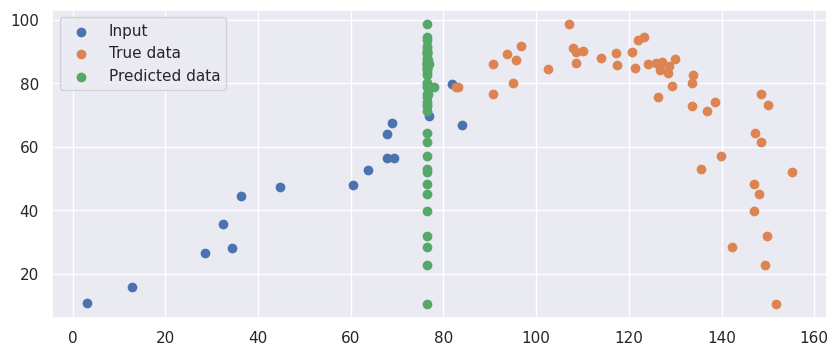

In [ ]:
# Plot prediction and the true values
data_distance = distance.iloc[17:]
data_height = test_launch["Height (m)"].iloc[17:]

# Run predictions through the model to get the next time step
predictions = [distance_in[-1][i,0] for i in range(k)]
for i in range(len(data_distance)):
  # Get the k previous steps
  i_input = np.array([predictions[-i] for i in range(k,0,-1)])
  prediction = distance_model(i_input.reshape((1,k,1)))
  # Convert single value matrix to just a number
  predictions.append(np.array(prediction)[0][0])

# Cut out first k predictions (that we actually already knew)
predictions = np.array(predictions[k:])

# Plot
plt.close('all')
plt.figure(figsize=(10,4))
plt.scatter(quarter_distance, quarter_height, label="Input")
plt.scatter(data_distance, data_height, label="True data")
plt.scatter(predictions, data_height, label="Predicted data")
plt.legend()
plt.show()

Well, those predictions are no good!
Apparently, our model is unable to predict the next portion of the data..
This is because the model is not good at "extrapolation" or predicting beyond where it was trained (this is more common for nonlinear models like our recurrent neural network than for linear models like ARMA because they are more flexible).
Note that all of the input data is in the range 0 to 75.
It seems that as soon as we give data beyond that, the model spits out values that it has seen before.

One way to avoid this issue would be to first make our data stationary or close to stationary (see the previously referenced [notebook](https://github.com/GDS-Education-Community-of-Practice/DSECOP/blob/main/Time_Series_Analysis_and_Forecasting/02_Time_Series_Analysis_and_Forecasting.ipynb) for more information).
We can do this by subtracting the data at the previous time from the current data.
Our new stationary distance will then be in the range of the training data and work better with our network.

In [ ]:
keras.utils.set_random_seed(0)

# Take the first quarter of the data (stationary)
original_distance = test_launch["Distance (m)"].shift()
distance = test_launch["Distance (m)"] - test_launch["Distance (m)"].shift()
quarter_distance = np.array(distance.iloc[1:17])
quarter_height = np.array(test_launch["Height (m)"].iloc[1:17])

# Organize the data for our recurrent neural network
k = 2
distance_in = []
distance_out = []
for i in range(len(quarter_distance)-k):
  # Take k samples at time t_i ... t_{i+k-1}
  distance_in.append(quarter_distance[i:i+k].reshape((k,1)))
  # Get function output at time t_{i+k}
  distance_out.append(quarter_distance[i+k])

distance_in = np.array(distance_in)
distance_out = np.array(distance_out)

Now, we can make a new model and train it with this new stationary data.

In [ ]:
# Make simple many to one model (input 2 samples of size 1)
x = keras.layers.Input(shape=(k,1))
y = keras.layers.SimpleRNN(10,activation="tanh", return_sequences=True)(x)
y = keras.layers.SimpleRNN(1,activation="linear", return_sequences=False)(y)
distance_model  = keras.Model(inputs=x,outputs=y)

# Train model
distance_model.compile(
    optimizer = keras.optimizers.Adam(),
    loss = keras.losses.MeanSquaredError()
)
history = distance_model.fit(
    distance_in,
    distance_out,
    batch_size=10,         # The training takes groups of samples (in this case 10 samples at a time)
    epochs=2000,           # The number of times to iterate through our dataset
    validation_split = 0,  # Use 0% of data to check accuracy
    verbose=0,             # Don't print info as it trains
    callbacks=[TqdmCallback(verbose=0)]
)

0epoch [00:00, ?epoch/s]

And now we can make and plot the predictions.

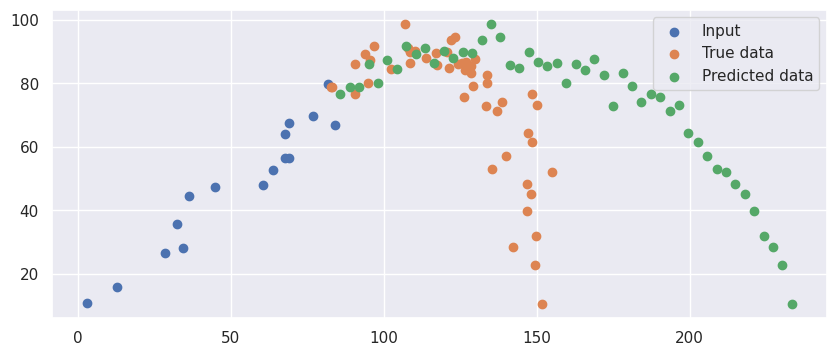

In [ ]:
# Plot prediction and the true values
data_distance = distance.iloc[17:]
data_height = test_launch["Height (m)"].iloc[17:]

# Run predictions through the model to get the next time step
predictions = [distance_in[-1][i,0] for i in range(k)]
for i in range(len(data_distance)):
  # Get the k previous steps
  i_input = np.array([predictions[-i] for i in range(k,0,-1)])
  prediction = distance_model(i_input.reshape((1,k,1)))
  # Convert single value matrix to just a number
  predictions.append(np.array(prediction)[0][0])

# Cut out first k predictions (that we actually already knew)
predictions = np.array(predictions[k:])

# Shift data and predictions
shift_quarter_distance = quarter_distance+original_distance.iloc[1:17]
shift_data_distance = data_distance+original_distance.iloc[17:]
shift_predictions = [predictions[0]+original_distance.iloc[17]]
for pred in predictions[1:]:
  shift_predictions.append(pred + shift_predictions[-1])

# Plot
plt.close('all')
plt.figure(figsize=(10,4))
plt.scatter(shift_quarter_distance, quarter_height, label="Input")
plt.scatter(shift_data_distance, data_height, label="True data")
plt.scatter(shift_predictions, data_height, label="Predicted data")
plt.legend()
plt.show()

Well that worked enormously better!
But the results still look somewhat equivalent to the linear models of ARMA in the previously referenced [notebook](https://github.com/GDS-Education-Community-of-Practice/DSECOP/blob/main/Time_Series_Analysis_and_Forecasting/02_Time_Series_Analysis_and_Forecasting.ipynb).

---

## <span style="color:Orange">Problem 1</span>

Try adding more `SimpleRNN` layers, changing the number of nodes in the layers, adding more training `epochs`, and adjusting the number of time points `k` for the dataset to acheive more accurate results. Remake the last plot above with this better tuned hyperparameters.

How close can you get to a good prediction of the projectile data?

*Note:* It is recommended that you change one at a time to see how each component affects the results.

In [ ]:
# YOUR CODE HERE
keras.utils.set_random_seed(0)

# Take the first quarter of the data (stationary)
original_distance = test_launch["Distance (m)"].shift()
distance = test_launch["Distance (m)"] - test_launch["Distance (m)"].shift()
quarter_distance = np.array(distance.iloc[1:17])
quarter_height = np.array(test_launch["Height (m)"].iloc[1:17])

# Organize the data for our recurrent neural network
k = 2
distance_in = []
distance_out = []
for i in range(len(quarter_distance)-k):
  # Take k samples at time t_i ... t_{i+k-1}
  distance_in.append(quarter_distance[i:i+k].reshape((k,1)))
  # Get function output at time t_{i+k}
  distance_out.append(quarter_distance[i+k])

distance_in = np.array(distance_in)
distance_out = np.array(distance_out)

# Make simple many to one model (input 2 samples of size 1)
x = keras.layers.Input(shape=(k,1))
y = keras.layers.SimpleRNN(10,activation="tanh", return_sequences=True)(x)
y = keras.layers.SimpleRNN(15,activation="tanh", return_sequences=True)(y)
y = keras.layers.SimpleRNN(1,activation="linear", return_sequences=False)(y)
distance_model  = keras.Model(inputs=x,outputs=y)

# Train model
distance_model.compile(
    optimizer = keras.optimizers.Adam(),
    loss = keras.losses.MeanSquaredError()
)
history = distance_model.fit(
    distance_in,
    distance_out,
    batch_size=10,         # The training takes groups of samples (in this case 10 samples at a time)
    epochs=1000,           # The number of times to iterate through our dataset
    validation_split = 0.1,  # Use 10% of data to check accuracy
    verbose=0,             # Don't print info as it trains
    callbacks=[TqdmCallback(verbose=0)]
)

0epoch [00:00, ?epoch/s]

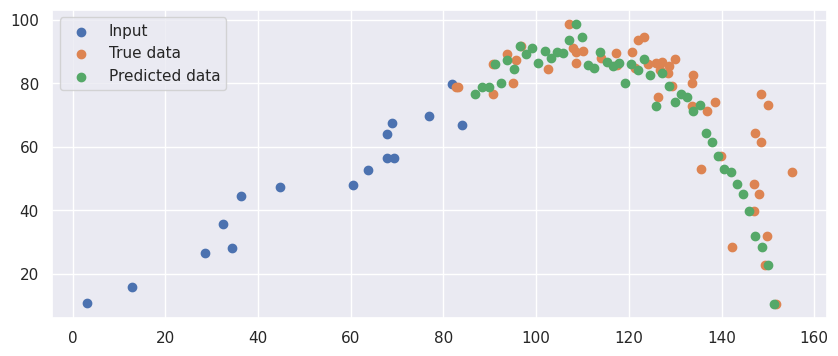

In [ ]:
# Plot prediction and the true values
data_distance = distance.iloc[17:]
data_height = test_launch["Height (m)"].iloc[17:]

# Run predictions through the model to get the next time step
predictions = [distance_in[-1][i,0] for i in range(k)]
for i in range(len(data_distance)):
  # Get the k previous steps
  i_input = np.array([predictions[-i] for i in range(k,0,-1)])
  prediction = distance_model(i_input.reshape((1,k,1)))
  # Convert single value matrix to just a number
  predictions.append(np.array(prediction)[0][0])

# Cut out first k predictions (that we actually already knew)
predictions = np.array(predictions[k:])

# Shift data and predictions
shift_quarter_distance = quarter_distance+original_distance.iloc[1:17]
shift_data_distance = data_distance+original_distance.iloc[17:]
shift_predictions = [predictions[0]+original_distance.iloc[17]]
for pred in predictions[1:]:
  shift_predictions.append(pred + shift_predictions[-1])

# Plot
plt.close('all')
plt.figure(figsize=(10,4))
plt.scatter(shift_quarter_distance, quarter_height, label="Input")
plt.scatter(shift_data_distance, data_height, label="True data")
plt.scatter(shift_predictions, data_height, label="Predicted data")
plt.legend()
plt.show()

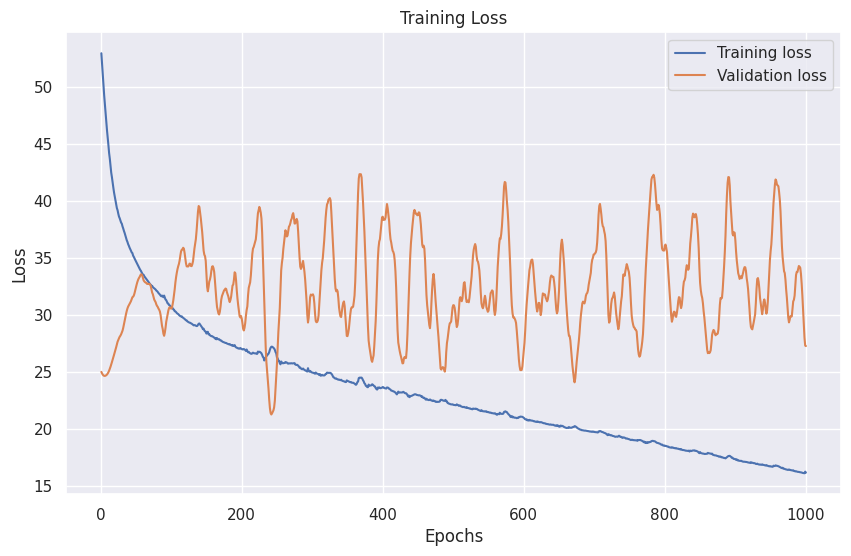

In [ ]:
# Chatgpt helped me make some of this function quickly
def plot_rnn_training_loss(history):
    """
    Plots the training loss of a Keras RNN model.

    Parameters:
    - history: The history callback object returned from the `fit` method of a Keras model.

    Returns:
    - A plot showing the training loss over epochs.
    """
    # Extract loss values from the history object
    loss = history.history['loss']
    val = history.history['val_loss']
    epochs = range(1, len(loss) + 1)

    # Plotting the loss
    plt.figure(figsize=(10, 6))
    plt.plot(epochs, loss, label='Training loss')
    plt.plot(epochs, val, label='Validation loss')
    plt.title('Training Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()
plot_rnn_training_loss(history)

----

Now, up until now, our data has been entirely based on the distance information.
However, our dataset contains more than just distance.
Also, notably, classical linear models such as ARMA cannot easily incorporate more than one variable.
But neural networks are very well suited to high dimensional data.

What if we also include the height variable in the training and prediction?

0epoch [00:00, ?epoch/s]

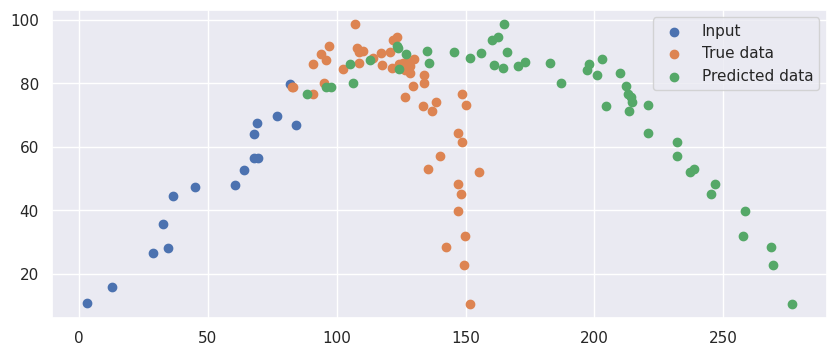

In [ ]:
keras.utils.set_random_seed(0)

# Take the first quarter of the data (stationary)
original_dh = test_launch[["Distance (m)", "Height (m)"]].shift()
dh_data = test_launch[["Distance (m)", "Height (m)"]] - test_launch[["Distance (m)", "Height (m)"]].shift()
quarter_dh = np.array(dh_data.iloc[1:17])
quarter_height = np.array(test_launch["Height (m)"].iloc[1:17])

# Organize the data for our recurrent neural network
k = 4
dh_in = []
distance_out = []
for i in range(len(quarter_dh)-k):
  # Take k samples at time t_i ... t_{i+k-1}
  dh_in.append(quarter_dh[i:i+k])
  # Get function output at time t_{i+k}
  distance_out.append(quarter_dh[i+k,0])

dh_in = np.array(dh_in)
distance_out = np.array(distance_out)

# Make simple many to one model (input 2 samples of size 2 variables)
x = keras.layers.Input(shape=(k,2))
y = keras.layers.SimpleRNN(10,activation="tanh", return_sequences=True)(x)
y = keras.layers.SimpleRNN(1,activation="linear", return_sequences=False)(y)
dh_model  = keras.Model(inputs=x,outputs=y)

# Train model
dh_model.compile(
    optimizer = keras.optimizers.Adam(),
    loss = keras.losses.MeanSquaredError()
)
history = dh_model.fit(
    dh_in,
    distance_out,
    batch_size=10,         # The training takes groups of samples (in this case 10 samples at a time)
    epochs=2000,           # The number of times to iterate through our dataset
    validation_split = 0,  # Use 0% of data to check accuracy
    verbose=0,             # Don't print info as it trains
    callbacks=[TqdmCallback(verbose=0)]
)

# Plot prediction and the true values
data_distance = test_launch["Distance (m)"].iloc[17:]
data_height = test_launch["Height (m)"].iloc[17:]

# Run predictions through the model to get the next time step
predictions = [dh_in[-1][i,0] for i in range(k)]
for i in range(len(data_distance)):
  # Get the k previous steps of height and with predicted distance
  i_input = np.vstack([
      np.array([predictions[-i] for i in range(k,0,-1)]),
      np.array([dh_data["Height (m)"].iloc[17+i-j] for j in range(k,0,-1)])
  ]).T
  prediction = dh_model(i_input.reshape((1,k,2)))
  # Convert single value matrix to just a number
  predictions.append(np.array(prediction)[0][0])

# Cut out first k predictions (that we actually already knew)
predictions = np.array(predictions[k:])

# Shift data and predictions
shift_quarter_distance = quarter_dh[:,0]+original_dh["Distance (m)"].iloc[1:17]
shift_data_distance = data_distance
shift_predictions = [predictions[0]+original_dh["Distance (m)"].iloc[17]]
for pred in predictions[1:]:
  shift_predictions.append(pred + shift_predictions[-1])

# Plot
plt.close('all')
plt.figure(figsize=(10,4))
plt.scatter(shift_quarter_distance, quarter_height, label="Input")
plt.scatter(shift_data_distance, data_height, label="True data")
plt.scatter(shift_predictions, data_height, label="Predicted data")
plt.legend()
plt.show()

This result doesn't look too different from our previous result, but notice that we needed to change to use `k=4` previous time points to make the prediction.

You can try to use `k=2` to see the interesting predictions that it yields (because the height values repeat themselves when the projectile comes back down, the predictions show distance decreasing!).

---

## <span style="color:Orange">Problem 2</span>

Using the example above, include the other variables in our dataset.
Namely, include the drag coefficient and projectile area.

Do these help with the prediction accuracy (without changing anything else)?
Why or why not might that be?

In [ ]:
# YOUR CODE HERE
keras.utils.set_random_seed(0)
# print(test_launch.describe())
# Take the first quarter of the data (stationary)
original_dh = test_launch[["Distance (m)", "Height (m)", "Drag coefficient", "Projectile area (m^2)"]].shift()
dh_data = test_launch[["Distance (m)", "Height (m)", "Drag coefficient", "Projectile area (m^2)"]] - test_launch[["Distance (m)", "Height (m)", "Drag coefficient", "Projectile area (m^2)"]].shift()
quarter_dh = np.array(dh_data.iloc[1:17])
quarter_height = np.array(test_launch["Height (m)"].iloc[1:17])


# Organize the data for our recurrent neural network
k = 4
dh_in = []
distance_out = []
for i in range(len(quarter_dh)-k):
  # Take k samples at time t_i ... t_{i+k-1}
  dh_in.append(quarter_dh[i:i+k])
  # Get function output at time t_{i+k}
  distance_out.append(quarter_dh[i+k,0])

dh_in = np.array(dh_in)
distance_out = np.array(distance_out)

# Make simple many to one model (input 2 samples of size 2 variables)
x = keras.layers.Input(shape=(k,4))
y = keras.layers.SimpleRNN(10,activation="tanh", return_sequences=True)(x)
y = keras.layers.SimpleRNN(1,activation="linear", return_sequences=False)(y)
dh_model  = keras.Model(inputs=x,outputs=y)

# Train model
dh_model.compile(
    optimizer = keras.optimizers.Adam(),
    loss = keras.losses.MeanSquaredError()
)
history = dh_model.fit(
    dh_in,
    distance_out,
    batch_size=10,         # The training takes groups of samples (in this case 10 samples at a time)
    epochs=2000,           # The number of times to iterate through our dataset
    validation_split = 0,  # Use 0% of data to check accuracy
    verbose=0,             # Don't print info as it trains
    callbacks=[TqdmCallback(verbose=0)]
)


0epoch [00:00, ?epoch/s]

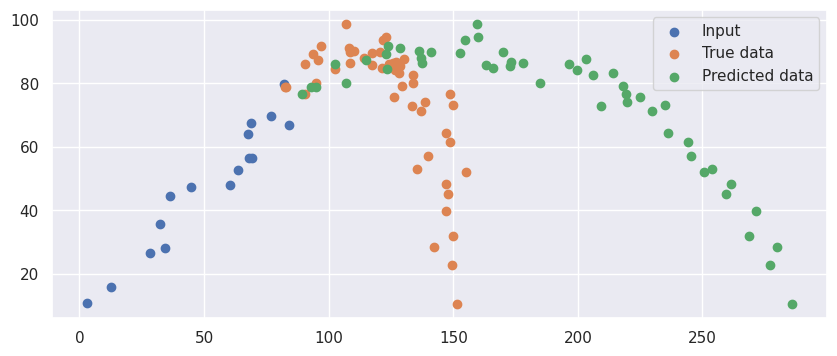

In [ ]:
# Plot prediction and the true values
data_distance = test_launch["Distance (m)"].iloc[17:]
data_height = test_launch["Height (m)"].iloc[17:]

# Run predictions through the model to get the next time step
predictions = [dh_in[-1][i,0] for i in range(k)]
for i in range(len(data_distance)):
  # Get the k previous steps of height and with predicted distance
  i_input = np.vstack([
      np.array([predictions[-i] for i in range(k,0,-1)]),
      np.array([dh_data["Height (m)"].iloc[17+i-j] for j in range(k,0,-1)]),
      np.array([dh_data["Drag coefficient"].iloc[17+i-j] for j in range(k,0,-1)]),
      np.array([dh_data["Projectile area (m^2)"].iloc[17+i-j] for j in range(k,0,-1)])
  ]).T
  prediction = dh_model(i_input.reshape((1,k,4)))
  # Convert single value matrix to just a number
  predictions.append(np.array(prediction)[0][0])

# Cut out first k predictions (that we actually already knew)
predictions = np.array(predictions[k:])

# Shift data and predictions
shift_quarter_distance = quarter_dh[:,0]+original_dh["Distance (m)"].iloc[1:17]
shift_data_distance = data_distance
shift_predictions = [predictions[0]+original_dh["Distance (m)"].iloc[17]]
for pred in predictions[1:]:
  shift_predictions.append(pred + shift_predictions[-1])

# Plot
plt.close('all')
plt.figure(figsize=(10,4))
plt.scatter(shift_quarter_distance, quarter_height, label="Input")
plt.scatter(shift_data_distance, data_height, label="True data")
plt.scatter(shift_predictions, data_height, label="Predicted data")
plt.legend()
plt.show()

Including the drag and area doesn't seem to help with the prediction at all.
This may be because the drag and area both assist in determining the jump in the distance between time points, which is already captured fairly well by the previous distance points.
In other words, the drag and area are almost redundant information given the previous distance samples.

----

## <span style="color:Orange">Problem 3</span>

So far, we have only used a single test launch.
However, the network training can be improved by incorporating all of the launches.
In fact, all of the launches can be used in their entirety to train the network, after which we can test it on the case we have been considering.

In this problem, fit (or train) the network on all of the data contained in `launches` except for the 20th entry (which is `test_launch`), then predict on the last 3/4 of the data from `test_launch` as the previous examples and problems have shown (which envisions only seeing the first part of the trajectory and needing to know the rest).
The notebook cell for organizing the stationary data earlier in the notebook is a good starting point for what to change to add all the launches in.

*Note:* You will likely need to decrease the number of `epochs` due to the much larger dataset.
Also, use `np.any(np.isnan())` to make sure you don't add anything with `NaN` (not a number) to the dataset.

*Help:* To work with the `all_launches` Pandas dataset, [this cheatsheet](https://pandas.pydata.org/Pandas_Cheat_Sheet.pdf) may be helpful.

In [ ]:
# YOUR CODE HERE
raise NotImplementedError()

The prediction with your RNN should be spot on!

## <span style="color:Orange">Appendix</span>

### <span style="color:LightGreen">Additional Information</span>

There are many drawbacks with the recurrent neural network architecture as presented in this notebook (such as training difficulties with vanishing gradients or lack of generalizability).
More complicated but improved alternatives that could be used as replacements for the `SimpleRNN` layer used in this notebook are:

- [`LSTM`](https://keras.io/api/layers/recurrent_layers/lstm/) which is described [here](https://en.wikipedia.org/wiki/Long_short-term_memory)
-[`GRU`](https://keras.io/api/layers/recurrent_layers/gru/) which is described [here](https://en.wikipedia.org/wiki/Gated_recurrent_unit)

### <span style="color:LightGreen">Resources</span>

- https://towardsdatascience.com/time-series-forecasting-deep-learning-vs-statistics-who-wins-c568389d02df
- https://neptune.ai/blog/time-series-prediction-vs-machine-learning

## <span style="color:Orange">Acknowledgments</span>

* Initial version: Mark Neubauer
  * From APS GDS repository

© Copyright 2024